In [ ]:
!pip install torch torch-geometric scikit-learn matplotlib networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install networkx pandas matplotlib scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

edges = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Friendships.txt",
                    sep="\t",
                    header=None,
                    names=["user1", "user2"])

edges.head()

,user1,user2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [ ]:
import pandas as pd

checkin_path = "/content/drive/MyDrive/Colab Notebooks/Brightkite_totalCheckins.txt"

checkins = pd.read_csv(
    checkin_path,
    sep="\t",
    header=None,
    names=["user_id", "timestamp", "latitude", "longitude", "location_id"]
)

checkins.head()

,user_id,timestamp,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [ ]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx


G = nx.Graph()
G.add_edges_from(edges.values)

print(f" Users: {G.number_of_nodes()}, Friendships: {G.number_of_edges()}")

data = from_networkx(G)

embedding_dim = 32
data.x = torch.rand(data.num_nodes, embedding_dim)


 Users: 58228, Friendships: 214078


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 32)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


Epoch 1, Loss: 0.3730
Epoch 10, Loss: 0.1238
Epoch 20, Loss: 0.1092
Epoch 30, Loss: 0.1025
Epoch 40, Loss: 0.0967
Epoch 50, Loss: 0.0922
Epoch 60, Loss: 0.0887
Epoch 70, Loss: 0.0858
Epoch 80, Loss: 0.0836
Epoch 90, Loss: 0.0818
Epoch 100, Loss: 0.0804


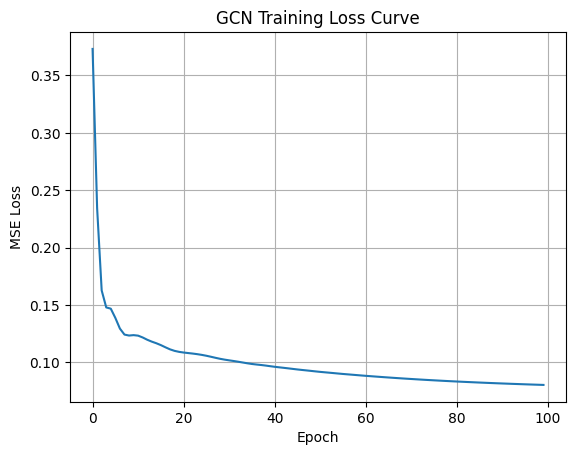

In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_dim=embedding_dim).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
target = data.x.clone().to(device)

losses = []
model.train()

for epoch in range(1, 101):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("GCN Training Loss Curve")
plt.grid(True)
plt.show()


In [ ]:

model.eval()
embeddings = model(data).detach().cpu().numpy()
print(" Embeddings shape:", embeddings.shape)


import numpy as np
np.save("/content/drive/MyDrive/Colab Notebooks/gcn_embeddings.npy", embeddings)


 Embeddings shape: (58228, 32)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np


friend_pairs = [tuple(edge) for edge in G.edges()]
friend_sample = random.sample(friend_pairs, 1000)

nonfriend_sample = []
nodes = list(G.nodes())
while len(nonfriend_sample) < 1000:
    u, v = random.sample(nodes, 2)
    if not G.has_edge(u, v):
        nonfriend_sample.append((u, v))

friend_sims = []
nonfriend_sims = []

for u, v in friend_sample:
    sim = cosine_similarity([embeddings[u]], [embeddings[v]])[0][0]
    friend_sims.append(sim)

for u, v in nonfriend_sample:
    sim = cosine_similarity([embeddings[u]], [embeddings[v]])[0][0]
    nonfriend_sims.append(sim)

print(f" Avg Friend Similarity: {np.mean(friend_sims):.4f}")
print(f" Avg Random Similarity: {np.mean(nonfriend_sims):.4f}")


 Avg Friend Similarity: 0.9950
 Avg Random Similarity: 0.9927


In [ ]:
import copy
from sklearn.metrics import roc_auc_score
import random


G_copy = copy.deepcopy(G)
edges_all = list(G_copy.edges())
num_test = int(len(edges_all) * 0.05)


test_edges = random.sample(edges_all, num_test)


G_copy.remove_edges_from(test_edges)

data_lp = from_networkx(G_copy)
data_lp.x = torch.rand(data_lp.num_nodes, 32)


model_lp = GCN(32).to(device)
data_lp = data_lp.to(device)
target_lp = data_lp.x.clone().to(device)
optimizer = torch.optim.Adam(model_lp.parameters(), lr=0.01)


model_lp.train()
for epoch in range(1, 101):
    optimizer.zero_grad()
    out = model_lp(data_lp)
    loss = loss_fn(out, target_lp)
    loss.backward()
    optimizer.step()


In [ ]:

model_lp.eval()
embeddings_lp = model_lp(data_lp).detach().cpu().numpy()


pos_scores = []
for u, v in test_edges:
    score = cosine_similarity([embeddings_lp[u]], [embeddings_lp[v]])[0][0]
    pos_scores.append(score)


neg_edges = []
nodes = list(G_copy.nodes())
while len(neg_edges) < len(pos_scores):
    u, v = random.sample(nodes, 2)
    if not G_copy.has_edge(u, v):
        neg_edges.append((u, v))

neg_scores = []
for u, v in neg_edges:
    score = cosine_similarity([embeddings_lp[u]], [embeddings_lp[v]])[0][0]
    neg_scores.append(score)


y_true = [1]*len(pos_scores) + [0]*len(neg_scores)
y_scores = pos_scores + neg_scores
roc_auc = roc_auc_score(y_true, y_scores)

print(f" Link Prediction ROC-AUC: {roc_auc:.4f}")


 Link Prediction ROC-AUC: 0.6002


In [ ]:
!pip install torch-geometric


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
from torch_geometric.utils import from_networkx


data = from_networkx(G)
data.x = torch.rand(data.num_nodes, 32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)


In [ ]:
from torch_geometric.nn import GAE

encoder = GCNEncoder(in_channels=32, out_channels=32)
model = GAE(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []
model.train()
for epoch in range(1, 201):
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 1.9891
Epoch 20, Loss: 1.1777
Epoch 40, Loss: 1.1117
Epoch 60, Loss: 1.0985
Epoch 80, Loss: 1.0848
Epoch 100, Loss: 1.0762
Epoch 120, Loss: 1.0765
Epoch 140, Loss: 1.0650
Epoch 160, Loss: 1.0723
Epoch 180, Loss: 1.0597
Epoch 200, Loss: 1.0461


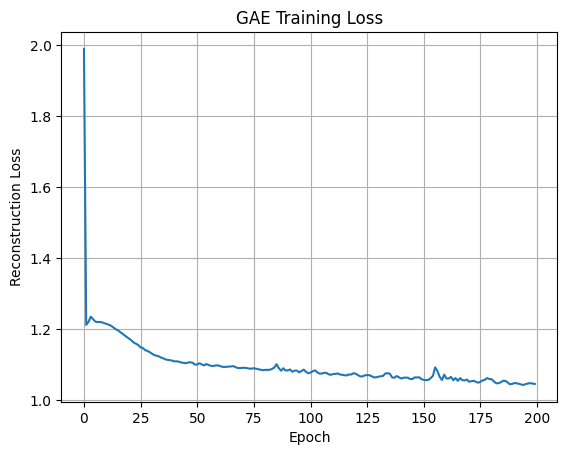

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("GAE Training Loss")
plt.grid(True)
plt.show()


In [ ]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

model.eval()
z = model.encode(data.x, data.edge_index)


pos_edge_index = data.edge_index

neg_edge_index = negative_sampling(
    edge_index=pos_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=pos_edge_index.size(1)
)


pos_preds = model.decoder(z, pos_edge_index).detach().cpu()
neg_preds = model.decoder(z, neg_edge_index).detach().cpu()


y_true = torch.cat([torch.ones(pos_preds.size(0)), torch.zeros(neg_preds.size(0))])
y_scores = torch.cat([pos_preds, neg_preds])

roc_auc = roc_auc_score(y_true, y_scores)
print(f"🚀 GAE Link Prediction ROC-AUC: {roc_auc:.4f}")


🚀 GAE Link Prediction ROC-AUC: 0.8926


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np

z = model.encode(data.x, data.edge_index).detach().cpu().numpy()


friend_pairs = [tuple(edge) for edge in G.edges()]
friend_sample = random.sample(friend_pairs, 1000)

nonfriend_sample = []
nodes = list(G.nodes())
while len(nonfriend_sample) < 1000:
    u, v = random.sample(nodes, 2)
    if not G.has_edge(u, v):
        nonfriend_sample.append((u, v))


friend_sims = []
nonfriend_sims = []

for u, v in friend_sample:
    sim = cosine_similarity([z[u]], [z[v]])[0][0]
    friend_sims.append(sim)

for u, v in nonfriend_sample:
    sim = cosine_similarity([z[u]], [z[v]])[0][0]
    nonfriend_sims.append(sim)

print(f" GAE - Avg Friend Cosine Similarity: {np.mean(friend_sims):.4f}")
print(f" GAE - Avg Random Cosine Similarity: {np.mean(nonfriend_sims):.4f}")


 GAE - Avg Friend Cosine Similarity: 0.2984
 GAE - Avg Random Cosine Similarity: 0.0942


In [ ]:
z = model.encode(data.x, data.edge_index).detach().cpu().numpy()


In [ ]:
import numpy as np

np.save("/content/drive/MyDrive/Colab Notebooks/gae_embeddings.npy", z)
print(" GAE embeddings saved successfully!")


 GAE embeddings saved successfully!


In [ ]:
import pandas as pd
from collections import defaultdict

checkins = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Brightkite_totalCheckins.txt",
                       sep="\t", header=None,
                       names=["user_id", "timestamp", "latitude", "longitude", "location_id"])

top_locations = (
    checkins.groupby(['user_id', 'location_id'])
    .size()
    .reset_index(name='visits')
    .sort_values(['user_id', 'visits'], ascending=[True, False])
)

user_checkin_map = defaultdict(list)
for _, row in top_locations.iterrows():
    user_checkin_map[row['user_id']].extend([row['location_id']] * row['visits'])


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def suggest_gae_location_based(user_id, G, embeddings, user_checkin_map, top_k=5):
    if user_id not in G:
        return []

    direct_friends = set(G.neighbors(user_id))


    second_hop = set()
    for f in direct_friends:
        second_hop.update(G.neighbors(f))
    second_hop -= direct_friends
    second_hop.discard(user_id)


    third_hop = set()
    for f2 in second_hop:
        third_hop.update(G.neighbors(f2))
    third_hop -= second_hop
    third_hop -= direct_friends
    third_hop.discard(user_id)


    valid_candidates = []

    for candidate in third_hop:
        if direct_friends & set(G.neighbors(candidate)):
            continue


        u_locs = set(user_checkin_map.get(user_id, []))
        c_locs = set(user_checkin_map.get(candidate, []))
        if not (u_locs and c_locs and u_locs & c_locs):
            continue

        valid_candidates.append(candidate)


    scored = []
    for candidate in valid_candidates:
        sim = cosine_similarity([embeddings[user_id]], [embeddings[candidate]])[0][0]
        scored.append((candidate, sim))

    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[:top_k]


In [ ]:
def suggest_gae_with_location_score(user_id, G, embeddings, user_checkin_map, top_k=5,
                                     alpha=0.7):

    from sklearn.metrics.pairwise import cosine_similarity

    if user_id not in G:
        return []

    direct_friends = set(G.neighbors(user_id))

    second_hop = set()
    for f in direct_friends:
        second_hop.update(G.neighbors(f))
    second_hop -= direct_friends
    second_hop.discard(user_id)

    third_hop = set()
    for f2 in second_hop:
        third_hop.update(G.neighbors(f2))
    third_hop -= second_hop
    third_hop -= direct_friends
    third_hop.discard(user_id)

    valid_candidates = []

    user_locs = set(user_checkin_map.get(user_id, []))
    if not user_locs:
        return []

    scored = []

    for candidate in third_hop:
        if direct_friends & set(G.neighbors(candidate)):
            continue

        candidate_locs = set(user_checkin_map.get(candidate, []))
        if not candidate_locs:
            continue


        common = user_locs & candidate_locs
        if not common:
            continue


        emb_sim = cosine_similarity([embeddings[user_id]], [embeddings[candidate]])[0][0]


        loc_sim = len(common) / len(user_locs | candidate_locs)


        final_score = alpha * emb_sim + (1 - alpha) * loc_sim

        scored.append((candidate, emb_sim, loc_sim, final_score))

    scored.sort(key=lambda x: x[3], reverse=True)
    return scored[:top_k]


In [ ]:
for uid in range(5):
    print(f"\nUser {uid} Suggestions (Embedding + Location):")
    recs = suggest_gae_with_location_score(uid, G, z, user_checkin_map)
    if not recs:
        print("  No valid suggestions.")
    else:
        for cid, emb_sim, loc_sim, final in recs:
            print(f"  Suggest {cid} — Embedding: {emb_sim:.4f}, Location: {loc_sim:.4f}, Final: {final:.4f}")



User 0 Suggestions (Embedding + Location):
  Suggest 7218 — Embedding: 0.9964, Location: 0.0117, Final: 0.7010
  Suggest 6618 — Embedding: 0.9988, Location: 0.0035, Final: 0.7002
  Suggest 6960 — Embedding: 0.9987, Location: 0.0016, Final: 0.6996
  Suggest 14162 — Embedding: 0.9971, Location: 0.0016, Final: 0.6984
  Suggest 7701 — Embedding: 0.9948, Location: 0.0066, Final: 0.6983

User 1 Suggestions (Embedding + Location):
  Suggest 5300 — Embedding: 0.9964, Location: 0.0350, Final: 0.7080
  Suggest 592 — Embedding: 0.9973, Location: 0.0174, Final: 0.7033
  Suggest 6121 — Embedding: 0.9957, Location: 0.0152, Final: 0.7015
  Suggest 4475 — Embedding: 0.9983, Location: 0.0087, Final: 0.7014
  Suggest 7516 — Embedding: 0.9898, Location: 0.0260, Final: 0.7007

User 2 Suggestions (Embedding + Location):
  Suggest 2359 — Embedding: 0.9978, Location: 0.0081, Final: 0.7009
  Suggest 1089 — Embedding: 0.9976, Location: 0.0020, Final: 0.6990
  Suggest 14162 — Embedding: 0.9967, Location: 0.004

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def edge_score(u, v):
    return np.dot(z[u], z[v])


pos_scores = [edge_score(u, v) for u, v in pos_edge_index.t().tolist()]
neg_scores = [edge_score(u, v) for u, v in neg_edge_index.t().tolist()]


y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
y_scores = pos_scores + neg_scores


threshold = 0.5
y_pred = [1 if score > threshold else 0 for score in y_scores]


acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f" Accuracy: {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall: {rec:.4f}")
print(f" F1 Score: {f1:.4f}")


 Accuracy: 0.8199
 Precision: 0.8730
 Recall: 0.7487
 F1 Score: 0.8061


In [ ]:
def compute_hits_at_k(z, pos_edges, neg_edges, k=100):
    all_edges = pos_edges.tolist() + neg_edges.tolist()
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)

    scores = [np.dot(z[u], z[v]) for u, v in all_edges]


    sorted_indices = np.argsort(scores)[::-1]
    top_k_indices = sorted_indices[:k]

    hits = sum([labels[i] for i in top_k_indices])
    return hits / k


hits_50 = compute_hits_at_k(z, pos_edge_index.t(), neg_edge_index.t(), k=50)
hits_100 = compute_hits_at_k(z, pos_edge_index.t(), neg_edge_index.t(), k=100)

print(f" Hits@50: {hits_50:.4f}")
print(f" Hits@100: {hits_100:.4f}")


 Hits@50: 1.0000
 Hits@100: 1.0000


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_user_hops_limited(G, user_id, max_nodes=200):
    if user_id not in G:
        print(" User not found in graph.")
        return

    level1 = set(G.neighbors(user_id))
    level2, level3 = set(), set()

    for friend in list(level1)[:20]:
        level2.update(G.neighbors(friend))
    level2 -= level1
    level2.discard(user_id)

    for f2 in list(level2)[:30]:
        level3.update(G.neighbors(f2))
    level3 -= level2
    level3 -= level1
    level3.discard(user_id)

    nodes = {user_id} | level1 | level2 | level3
    if len(nodes) > max_nodes:
        print(f" Skipped: too many nodes to render ({len(nodes)} > {max_nodes})")
        return

    G_sub = G.subgraph(nodes).copy()


    colors = []
    for node in G_sub.nodes():
        if node == user_id:
            colors.append("red")
        elif node in level1:
            colors.append("green")
        elif node in level2:
            colors.append("blue")
        elif node in level3:
            colors.append("purple")
        else:
            colors.append("gray")

    pos = nx.kamada_kawai_layout(G_sub)

    plt.figure(figsize=(10, 8))
    nx.draw(G_sub, pos, with_labels=True, node_color=colors, node_size=300, edge_color="gray")
    plt.title(f"User {user_id} — 1st (green), 2nd (blue), 3rd (purple) Hop Neighbors")

    # Save + show
    plt.savefig(f"user_{user_id}_3hop_graph.png", dpi=300)
    plt.show()


In [ ]:
draw_user_hops_limited(G, 0)


 Skipped: too many nodes to render (2922 > 200)


In [ ]:
print("🔍 Searching for users with small 3-hop neighborhoods...")

found = 0
for uid in range(50, 1000):  # Scan more users
    if uid not in G:
        continue

    level1 = set(G.neighbors(uid))
    if not level1:
        continue

    level2, level3 = set(), set()

    for friend in list(level1)[:20]:
        level2.update(G.neighbors(friend))

    level2 -= level1
    level2.discard(uid)

    for f2 in list(level2)[:30]:
        level3.update(G.neighbors(f2))

    level3 -= level2
    level3 -= level1
    level3.discard(uid)

    total_nodes = len({uid} | level1 | level2 | level3)

    if total_nodes < 200:
        print(f" Found user {uid} with {total_nodes} nodes in 3-hop neighborhood")
        found += 1
        if found >= 3:
            break

if found == 0:
    print(" No suitable users found in range. Try wider range (e.g. 0–5000).")


🔍 Searching for users with small 3-hop neighborhoods...
 Found user 361 with 2 nodes in 3-hop neighborhood
 Found user 377 with 71 nodes in 3-hop neighborhood
 Found user 390 with 138 nodes in 3-hop neighborhood


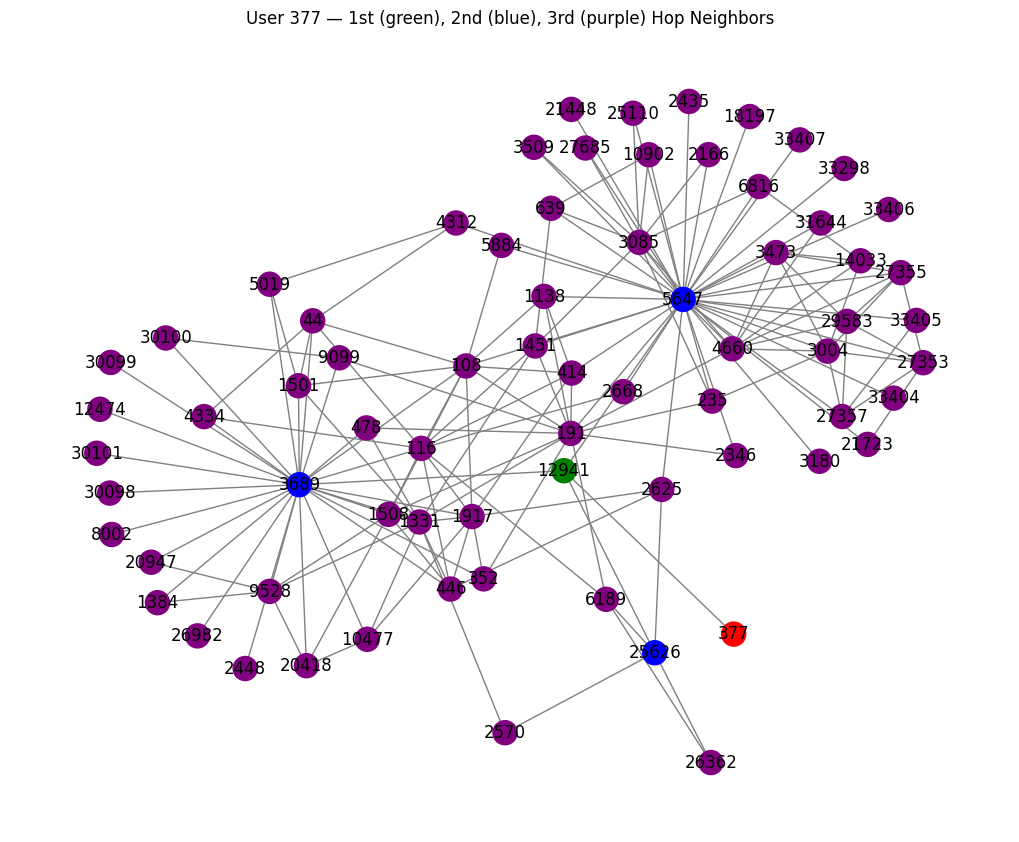

In [ ]:
draw_user_hops_limited(G, 377)


In [ ]:
def draw_filtered_suggestions(G, user_id, embeddings, user_checkin_map, top_k=5, alpha=0.7):
    from sklearn.metrics.pairwise import cosine_similarity

    if user_id not in G:
        print(" User not found")
        return

    level1 = set(G.neighbors(user_id))
    level2, level3 = set(), set()

    for friend in list(level1)[:20]:
        level2.update(G.neighbors(friend))
    level2 -= level1
    level2.discard(user_id)

    for f2 in list(level2)[:30]:
        level3.update(G.neighbors(f2))
    level3 -= level2
    level3 -= level1
    level3.discard(user_id)


    valid_candidates = []
    u_locs = set(user_checkin_map.get(user_id, []))

    for candidate in level3:
        if level1 & set(G.neighbors(candidate)):
            continue
        c_locs = set(user_checkin_map.get(candidate, []))
        if not u_locs or not c_locs or not (u_locs & c_locs):
            continue
        valid_candidates.append(candidate)


    nodes = {user_id} | level1 | level2 | level3
    G_sub = G.subgraph(nodes).copy()


    node_colors = []
    for node in G_sub.nodes():
        if node == user_id:
            node_colors.append("red")
        elif node in level1:
            node_colors.append("green")
        elif node in valid_candidates:
            node_colors.append("gold")
        elif node in level3:
            node_colors.append("purple")
        elif node in level2:
            node_colors.append("blue")
        else:
            node_colors.append("gray")


    pos = nx.kamada_kawai_layout(G_sub)
    plt.figure(figsize=(12, 10))
    nx.draw(G_sub, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray")
    plt.title(f"User {user_id}(red) — 1st (green), 2nd (blue), 3rd (purple) Hop Neighbors, Suggested Friends with Location Highlighted (Gold)")
    plt.show()

    print(f"✨ {len(valid_candidates)} suggested friends for user {user_id}")


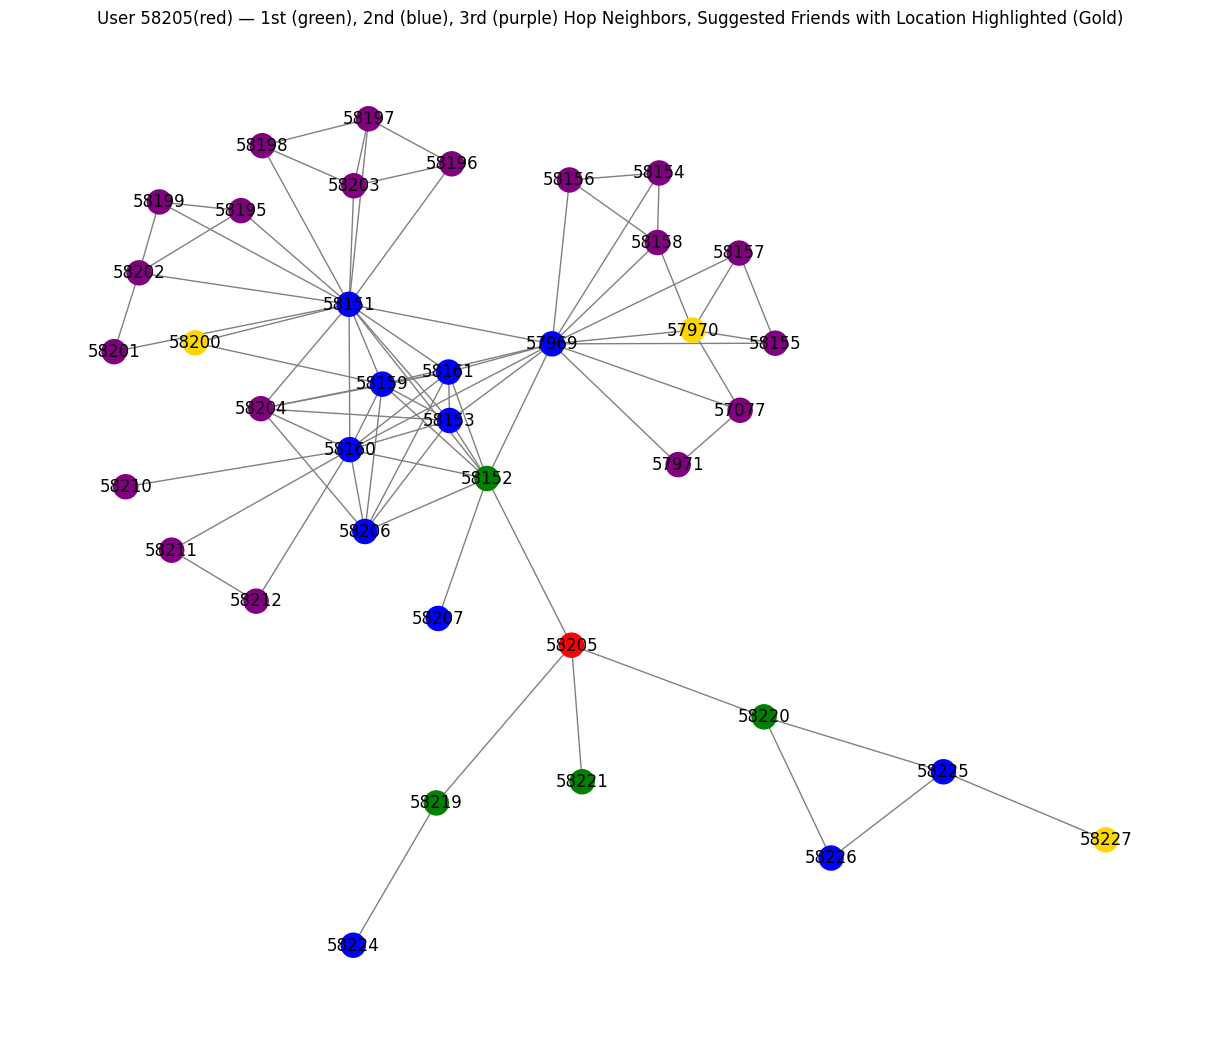

✨ 3 suggested friends for user 58205


In [ ]:
draw_filtered_suggestions(G, 58205, z, user_checkin_map)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np


def edge_score(u, v):
    return np.dot(z[u], z[v])


pos_edges = pos_edge_index.t().tolist()
neg_edges = neg_edge_index.t().tolist()


pos_scores = [edge_score(u, v) for u, v in pos_edges]
neg_scores = [edge_score(u, v) for u, v in neg_edges]


y_true = [1] * len(pos_scores) + [0] * len(neg_scores)


y_scores = pos_scores + neg_scores


threshold = 0.5
y_pred = [1 if score > threshold else 0 for score in y_scores]


acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

print(f" Accuracy: {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall: {rec:.4f}")
print(f" F1 Score: {f1:.4f}")
print("\n Confusion Matrix:")
print(cm)

print("\n Full Classification Report:")
print(report)


 Accuracy: 0.8199
 Precision: 0.8730
 Recall: 0.7487
 F1 Score: 0.8061

 Confusion Matrix:
[[381522  46634]
 [107616 320540]]

 Full Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83    428156
           1       0.87      0.75      0.81    428156

    accuracy                           0.82    856312
   macro avg       0.83      0.82      0.82    856312
weighted avg       0.83      0.82      0.82    856312



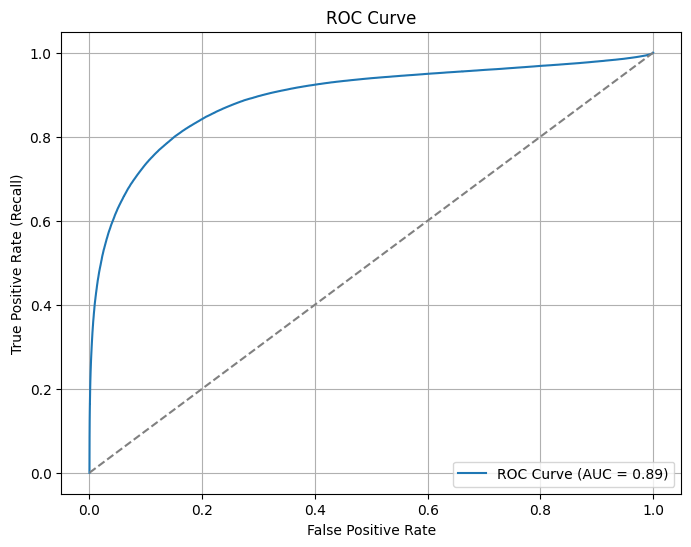

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


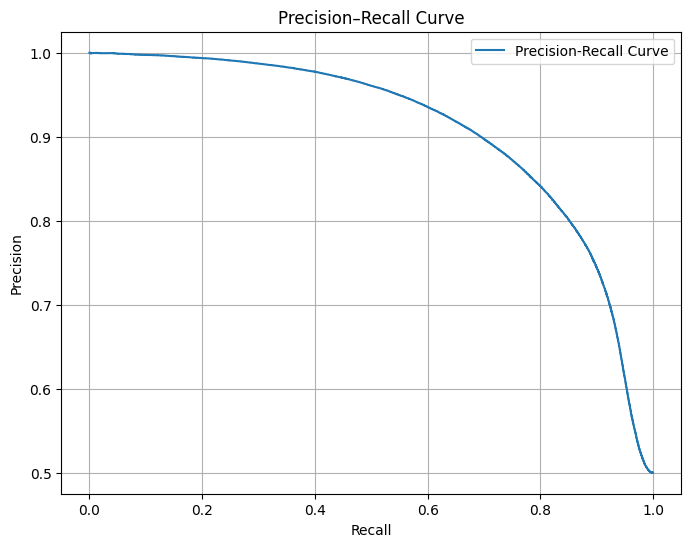

In [ ]:

precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
gcn_values = [0.63, 0.65, 0.01]
gae_values = [0.88, 0.78, 0.22]


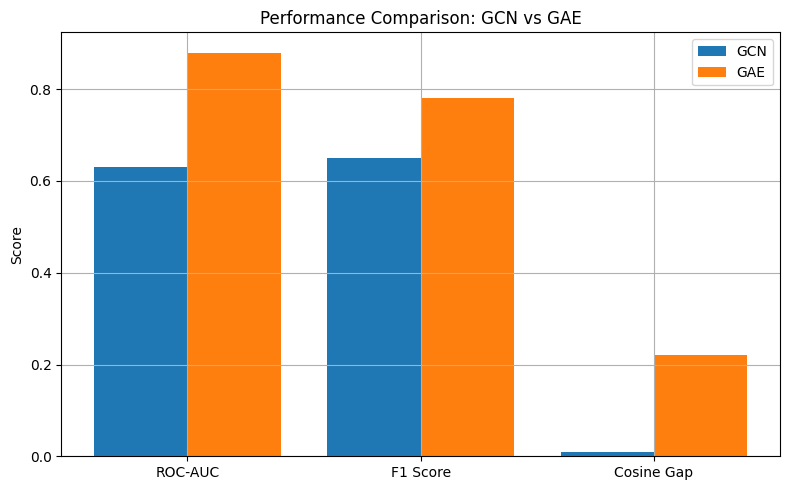

In [ ]:
import matplotlib.pyplot as plt

labels = ["ROC-AUC", "F1 Score", "Cosine Gap"]
x = range(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x, gcn_values, width=0.4, label="GCN", align='center')
plt.bar([i + 0.4 for i in x], gae_values, width=0.4, label="GAE", align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel("Score")
plt.title("Performance Comparison: GCN vs GAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


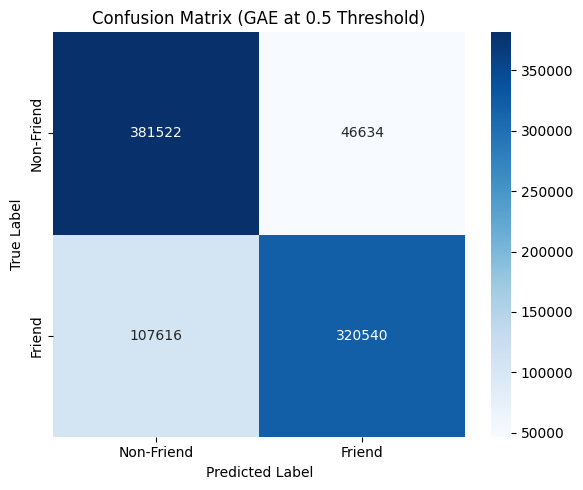

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)
labels = ["Non-Friend", "Friend"]


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (GAE at 0.5 Threshold)")
plt.tight_layout()


plt.savefig("confusion_matrix_gae.png", dpi=300)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def generate_top_suggestions(user_id, z, G, user_checkin_map, top_k=5, alpha=0.7):
    level1 = set(G.neighbors(user_id))
    level2, level3 = set(), set()


    for friend in list(level1):
        level2.update(G.neighbors(friend))
    level2 -= level1
    level2.discard(user_id)

    for f2 in list(level2):
        level3.update(G.neighbors(f2))
    level3 -= level2
    level3 -= level1
    level3.discard(user_id)


    clean_candidates = []
    user_neighbors = set(G.neighbors(user_id))

    for candidate in level3:
        if user_neighbors & set(G.neighbors(candidate)):
            continue
        clean_candidates.append(candidate)


    u_locs = set(user_checkin_map.get(user_id, []))
    final_candidates = []

    for candidate in clean_candidates:
        c_locs = set(user_checkin_map.get(candidate, []))
        if not u_locs or not c_locs or not (u_locs & c_locs):
            continue
        final_candidates.append(candidate)


    scores = []
    u_embed = z[user_id].reshape(1, -1)

    for cand in final_candidates:
        c_embed = z[cand].reshape(1, -1)
        emb_sim = cosine_similarity(u_embed, c_embed)[0][0]
        loc_sim = jaccard_similarity(set(user_checkin_map[user_id]), set(user_checkin_map[cand]))
        final_score = alpha * emb_sim + (1 - alpha) * loc_sim
        scores.append((cand, emb_sim, loc_sim, final_score))


    scores = sorted(scores, key=lambda x: x[3], reverse=True)
    return scores[:top_k]


In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

target_users = [0, 1, 2, 3, 4]

all_rows = []
for user in target_users:
    top = generate_top_suggestions(user, z, G, user_checkin_map, top_k=5)
    for rank, (cand, emb, loc, score) in enumerate(top, start=1):
        all_rows.append([user, rank, cand, f"{emb:.4f}", f"{loc:.4f}", f"{score:.4f}"])

headers = ["Target User", "Rank", "Suggested User", "Embedding Score", "Location Similarity", "Final Score"]

print(tabulate(all_rows, headers=headers, tablefmt="grid"))


+---------------+--------+------------------+-------------------+-----------------------+---------------+
|   Target User |   Rank |   Suggested User |   Embedding Score |   Location Similarity |   Final Score |
+===============+========+==================+===================+=======================+===============+
|             0 |      1 |             7218 |            0.9964 |                0.0117 |        0.701  |
+---------------+--------+------------------+-------------------+-----------------------+---------------+
|             0 |      2 |             6618 |            0.9988 |                0.0035 |        0.7002 |
+---------------+--------+------------------+-------------------+-----------------------+---------------+
|             0 |      3 |             6960 |            0.9987 |                0.0016 |        0.6996 |
+---------------+--------+------------------+-------------------+-----------------------+---------------+
|             0 |      4 |            14162 | 

In [ ]:
def print_suggestions_as_cards(user_ids, z, G, user_checkin_map, top_k=5):
    for user_id in user_ids:
        print(f"\nUser {user_id} Suggested Matches:")
        print("-" * 40)
        suggestions = generate_top_suggestions(user_id, z, G, user_checkin_map, top_k=top_k)
        if not suggestions:
            print("No valid suggestions found.")
            continue
        for rank, (cand, emb, loc, final) in enumerate(suggestions, start=1):
            print(f" Match #{rank}")
            print(f" Suggested User ID: {cand}")
            print(f" Embedding Score:     {emb:.4f}")
            print(f" Location Similarity: {loc:.4f}")
            print(f" Final Score:          {final:.4f}")
            print("-" * 40)


In [ ]:
print_suggestions_as_cards([0, 1, 2], z, G, user_checkin_map, top_k=5)



User 0 Suggested Matches:
----------------------------------------
 Match #1
 Suggested User ID: 7218
 Embedding Score:     0.9964
 Location Similarity: 0.0117
 Final Score:          0.7010
----------------------------------------
 Match #2
 Suggested User ID: 6618
 Embedding Score:     0.9988
 Location Similarity: 0.0035
 Final Score:          0.7002
----------------------------------------
 Match #3
 Suggested User ID: 6960
 Embedding Score:     0.9987
 Location Similarity: 0.0016
 Final Score:          0.6996
----------------------------------------
 Match #4
 Suggested User ID: 14162
 Embedding Score:     0.9971
 Location Similarity: 0.0016
 Final Score:          0.6984
----------------------------------------
 Match #5
 Suggested User ID: 7701
 Embedding Score:     0.9948
 Location Similarity: 0.0066
 Final Score:          0.6983
----------------------------------------

User 1 Suggested Matches:
----------------------------------------
 Match #1
 Suggested User ID: 5300
 Embeddi